In [ ]:
!pip install pytorch_lightning

In [ ]:
import colorsys
import math
import random

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid

ROOT = "train"

IMAGE_SIZE = 32

# Данные
Создадим корпус картинок с фигурами.

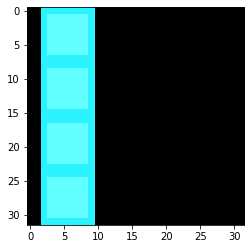

In [ ]:
def flat_rectangle(image, x, y, block_size, color):
    image[y:y + block_size, x:x + block_size] = color
    
def nested_rectangle(image, x, y, block_size, color):
    b = 1
    image[y:y + block_size, x:x + block_size] = color
    image[y + b:y + block_size - b, x + b:x + block_size - b] = color.clip(max=200) + 55
    
    
STYLES = [
    flat_rectangle,
    nested_rectangle
]


BLOCKS = [
    [[1, 0, 0],
     [1, 1, 1]],
    [[1, 1, 0],
     [0, 1, 1]],
    [[1, 1, 1, 1]],
    [[0, 1, 0],
     [1, 1, 1]],

]


def draw(block, image_size=32, rotate=False):
    color = colorsys.hsv_to_rgb(random.random(), random.random() * 0.5 + 0.5, 1)
    color = np.asarray([255 * c for c in color], dtype=np.uint8)
    block = np.asarray(block)
    style = random.choice(STYLES)
    if random.random() > 0.5:
        block = np.fliplr(block)
    if random.random() > 0.5:
        block = np.flipud(block)
    if random.random() > 0.5:
        block = block.T
    max_dim = max(block.shape[0], block.shape[1])
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    block_size = image_size // max_dim  # random.randint(image_size // 8, image_size // max_dim)
    width = block.shape[1] * block_size
    height = block.shape[0] * block_size
    x_offset = random.randint(0, image_size - width)
    y_offset = random.randint(0, image_size - height)
    for i, row in enumerate(block):
        for j, filled in enumerate(row):
            if not filled:
                continue
            x = x_offset + j * block_size
            y = y_offset + i * block_size
            style(image, x, y, block_size, color)
    image = Image.fromarray(image)
    if rotate:
        angle = random.random() * 360
        image = image.rotate(angle, center=(image_size // 2, image_size // 2),
                             resample=2)
    return image

plt.imshow(draw(random.choice(BLOCKS)))

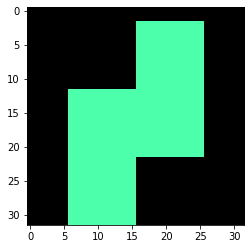

In [ ]:
class TetrisDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None, image_size=IMAGE_SIZE, n=2 ** 14):
        super().__init__()
        self._n = n
        self._transform = transform
        self._image_size = image_size
        
    @property
    def image_size(self):
        return self._image_size
        
    def __len__(self):
        return self._n
    
    def __getitem__(self, index):
        image = draw(random.choice(BLOCKS), image_size=self._image_size)
        if self._transform is not None:
            image = self._transform(image)
        return image

dataset = TetrisDataset()
plt.imshow(dataset[len(dataset) // 2])

# Реализуем простую модель, похожую на DCGAN
![DCGAN](dcgan.png "DCGAN")

**Задание 1.** Предлагается реализовать модель генератора. На вход генератор принимает тензор шума размера (BatchSize, HiddenSize, 1, 1). На выходе генерируется тензор изображений размера (BatchSize, 3, 32, 32). Предлагается использовать ConvTranspose2d, BatchNorm2d, ReLU и Tanh активацию на выходе.

ConvTranspose предлагается делать с ядром размера 4. ReLU можно сделать inplace для ускорения.

Размеры тензоров на промежуточных слоях должны иметь следующую последовательность:

(B, 64, 4, 4)

(B, 32, 8, 8)

(B, 16, 16, 16)

(B, 3, 32, 32)

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, image_size):
        super().__init__()
        assert image_size == 32
        self._hidden_size = 16
        final_channels = 16
        self.model = torch.nn.Sequential(
            nn.ConvTranspose2d(self._hidden_size, 64, 4, 1, bias = False), 
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1,  bias = False), 
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4,2,  1, bias = False), 
            nn.Tanh(),


            ### Конец вашего кода.
        )
        
    def forward(self, batch_size_or_noise):
        if isinstance(batch_size_or_noise, torch.Tensor):
            # Input is a noise tensor with shape (B, H, 1, 1).
            noise = batch_size_or_noise
        else:
            # Input is batch size.
            batch_size = batch_size_or_noise
            device = next(iter(self.parameters())).device
            noise = torch.randn(batch_size, self._hidden_size, 1, 1, device=device)
        return self.model(noise)
    
    
def num_parameters(model):
    n = sum(p.numel() for p in model.parameters())
    return n


def get_tensor_shapes(model, x):
    sizes = []
    for layer in model:
        x = layer(x)
        if hasattr(layer, "kernel_size"):
            sizes.append(x.shape[1:])
    return sizes


# Проверки.
generator = Generator(image_size=dataset.image_size)
shapes_gt = [(64, 4, 4), (32, 8, 8), (16, 16, 16), (3, 32, 32)]
for shape, shape_gt in zip(get_tensor_shapes(generator.model, torch.randn(5, 16, 1, 1)), shapes_gt):
    assert shape == shape_gt
assert isinstance(generator.model[-1], torch.nn.Tanh)
print(generator, get_tensor_shapes(generator.model, torch.randn(5, 16, 1, 1)))
print(num_parameters(generator), generator(5).shape)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(16, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
) [torch.Size([64, 4, 4]), torch.Size([32, 8, 8]), torch.Size([16, 16, 16]), torch.Size([3, 32, 32])]
58336 torch.Size([5, 3, 32, 32])


**Задание 2.** Предлагается реализовать модель дискриминатора. На вход дискриминатор принимает тензор изображений размера (BatchSize, 3, 32, 32). На выходе генерируется тензор логитов размера (BatchSize, 1, 1, 1). Предлагается использовать Conv2d, BatchNorm2d и LeakyReLU активацию. Сигмоиду к выходам применять не нужно.

Свертки предлагается делать с ядром размера 4. LeakyReLU можно сделать inplace для ускорения.

Размеры тензоров на промежуточных слоях должны иметь следующую последовательность:

(B, 16, 16, 16)

(B, 32, 8, 8)

(B, 64, 4, 4)

(B, 1, 1, 1)

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        assert image_size == 32
        init_channels = 16
        self.model = torch.nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, 4, 2, 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.2),

            nn.Conv2d(64, 1, 4, 2,  bias = False),
    

            
            ### Конец вашего кода.
        )

    def forward(self, x):
        logits = self.model(x).squeeze()
        return logits

discriminator = Discriminator(image_size=dataset.image_size)
shapes_gt = [(16, 16, 16), (32, 8, 8), (64, 4, 4), (1, 1, 1)]
for shape, shape_gt in zip(get_tensor_shapes(discriminator.model, torch.randn(5, 3, 32, 32)), shapes_gt):
    assert shape == shape_gt
print(get_tensor_shapes(discriminator.model, torch.randn(5, 3, 32, 32)))
print(discriminator)
print(num_parameters(discriminator), discriminator(generator(5)).shape)

[torch.Size([16, 16, 16]), torch.Size([32, 8, 8]), torch.Size([64, 4, 4]), torch.Size([1, 1, 1])]
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), 

# Тренировка

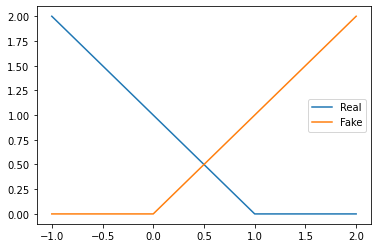

In [ ]:
def xent(logits, is_real, smooth=0.2):
    probs = torch.sigmoid(logits)
    label = 1 - smooth if is_real else smooth
    labels = torch.full_like(probs, label)
    return torch.nn.functional.binary_cross_entropy(probs, labels, reduction="none")


def mse(logits, is_real):
    return (logits - is_real).square()


def relu(logits, is_real):
    if is_real:
        return torch.clip(1 - logits, min=0)
    else:
        return torch.clip(logits, min=0)
    
    
criterion = relu

logits = torch.linspace(-1, 2, 100)
plt.plot(logits, criterion(logits, 1), label="Real")
plt.plot(logits, criterion(logits, 0), label="Fake")
plt.legend()
plt.show()

**Задание 3.** Реализовать training_step.

Используйте функцию criterion(logits, labels), которая вычисляет лосс.

Используйте self._generator(batch_size) для применения генератора и self._discriminator(images) для дискриминатора.

При оценке лосса дискримнатора стоит отключить пробрасывание градиентов в генератор (метод detach).

In [ ]:
from skimage.io import imsave

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)
        

class Module(pl.LightningModule):
    def __init__(self):
        super().__init__()
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
        ])
        self._dataset = TetrisDataset(transform=transform)
        self._generator = Generator(image_size=self._dataset.image_size)
        self._discriminator = Discriminator(image_size=self._dataset.image_size)
        self._generator.apply(weights_init)
        self._discriminator.apply(weights_init)
        
    def forward(self, batch_size, detach_generator=False):
        images = self._generator(batch_size)
        if detach_generator:
            images = images.detach()
        logits = self._discriminator(images)
        return images, logits
    
    def training_step(self, batch, batch_idx, optimizer_idx=0):
        fake = self._generator(len(batch))
        if optimizer_idx == 0:
            # Вычислим лосс генератора.
            
            ### Ваш код здесь.
            loss = criterion(self._discriminator(fake), 1).mean()
            ### Конец вашего кода.
            
            self.log("g_loss", loss, prog_bar=True)
        if optimizer_idx == 1:
            # Вычислим лосс дискриминатора.
              
            ### Ваш код здесь.
            real_loss = criterion(self._discriminator(batch), 1).mean()
            fake_loss = criterion(self._discriminator(fake.detach()), 0).mean()
            ### Конец вашего кода.
            
            self.log("d_r_loss", real_loss, prog_bar=True)
            self.log("d_f_loss", fake_loss, prog_bar=True)
            loss = real_loss + fake_loss
        return loss
        
    def configure_optimizers(self):
        g_optimizer = torch.optim.Adam(self._generator.parameters(),
                                       lr=0.01, betas=(0.5, 0.999))
        d_optimizer = torch.optim.Adam(self._discriminator.parameters(),
                                       lr=0.01, betas=(0.5, 0.999))
        return [g_optimizer, d_optimizer], []
        
    def train_dataloader(self):
        loader = torch.utils.data.DataLoader(self._dataset, batch_size=256,
                                             shuffle=True, drop_last=True)
        return loader
    
    def on_train_epoch_end(self):
        with torch.no_grad():
            generated, _ = self(16)
            grid = make_grid(generated, padding=0, normalize=True, nrow=4)
        image = (grid.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        imsave("grid.jpg", image)
        plt.imshow(image)
        plt.show()

    
def train(module):
    pl.seed_everything(0)
    trainer = pl.Trainer(default_root_dir=ROOT, accelerator="auto", max_epochs=1000)
    trainer.fit(module)

    
module = Module()
train(module)

**Домашнее задание (без оценки)**. Попробуйте добавить feature matching loss, self-attention или дополнительные головы дискриминатора. Попробуйте также учить дольше или подобрать параметры optimizer. Попробуйте добавить голову классификации типа фигурки на выход генератора. Попробуйте генерировать изображения большего размера (128x128). Попробуйте добавить повороты в исходный датасет.

Присылайте картинки в чат группы)